In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from cleaning_functions import q_cuts,field_check,filter_split,flux_unc_val
from astropy import coordinates as coord
from forced_phot import flux_jy
from scipy.optimize import curve_fit

from scipy.signal import find_peaks, peak_prominences

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

In [3]:
latest_peak =  2459783.499988 #jd of 31-07-2022 23:59:59.000

# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_ZTF_r_batchfp_req0000338730_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aauosxv\clean_ZTF_r_batchfp_req0000338734_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aavummp\clean_ZTF_r_batchfp_req0000338750_lc.txt'
# testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18aajupnt\clean_ZTF_r_batchfp_req0000338755_lc.txt'
testpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF19aaejtoy\ZTF19aaejtoy_clean_data.json'
ztf_name =os.path.split(testpath)[-1].split('_')[0]

# testfile = r'clean_ZTF_r_batchfp_req0000338730_lc.txt'
testdata = pd.read_json(testpath)

time = testdata['time']
flux,err = flux_jy(testdata)
flux = flux.values
maxtime = time.iloc[np.argmax(flux)]
maxflux = np.max(flux)

time_zp = time.min()
time = time.values - time_zp
latest_peak -= time_zp
t = time
print(time.shape,flux.shape,err.shape,latest_peak)

(850,) (850,) (850,) 1481.7465967996977


In [4]:
def plot_data(filepath,name=' '):
    testdata = pd.read_csv(filepath,delimiter=' ')
    time = testdata['time']
    flux,err = flux_jy(testdata)
    flux = flux.values
    time = time.values

    plt.figure()
    plt.title(f'R band data of {name}')
    plt.scatter(time,flux,s=4,label='Data')
    plt.legend()
    plt.show()

    return flux,time

## Testing peak finders

### Simple Gaussian $\chi^2$ fit

This needs to change such that the Gaussian options are taken not as the datapoints but between the minimum time in the data and July 2022 (as is the case now) with a timestep of 5 days. This can be done by not returning an array of values (since then chi2 cannot be evaluated bc the shapes don't match) but as a function. Ergo this means a Gaussian as a function with filled in parameters (namely mu) which may be evaluated at

Sum of flux is now 17.20645891219278


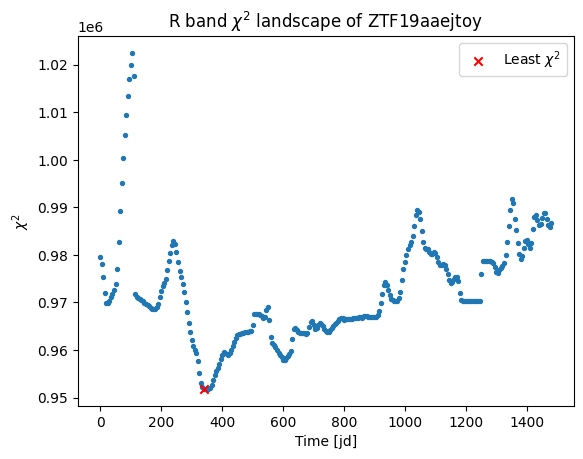

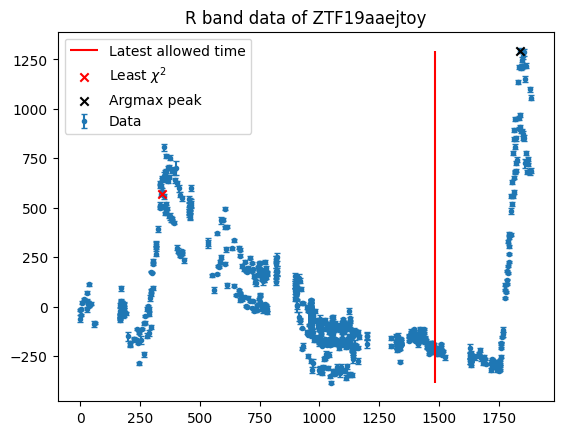

In [10]:
def chi2(flux,flux_err,model_fit):
    return np.sum(np.square(flux - model_fit)/np.square(flux_err))

#normalize data so that integral is 1 and amplitude need not be fitted
norm_flux = flux /np.max(flux) #/ np.sum(flux)
err_norm = err / np.max(flux) #/ np.sum(flux) #klopt als het goed is

print(f"Sum of flux is now {np.sum(norm_flux)}")

def gaussian(x,mu,amp=1,sigma=10):
    gauss = np.exp(-(np.square(x-mu)/(2*sigma**2)))
    return gauss/np.sum(gauss)


def chi2_peak_finder(flux = norm_flux,flux_err=err_norm,time=time):
    timesteps_for_gauss = np.arange(np.min(time),latest_peak,step=5) #key array that deduces the times which will become candidates

    chi2_results = np.full(timesteps_for_gauss.shape,np.nan) #fill array of size timesteps with nans
    for i,t in enumerate(timesteps_for_gauss):
        # fit = gaussian(flux,mu)
        if t < latest_peak:
            chi2_results[i] = chi2(flux,flux_err,gaussian(time,amp=1,mu=t))
    peak = np.nanargmin(chi2_results) #ignore the nans, find the least chi2

    #finding the flux of the closest corresponding time in the actual data as the corresponding flux to the peak guess
    best_time_insteps = timesteps_for_gauss[peak_index]
    best_fit_arg = np.argmin(np.abs(time - best_time_insteps))
    best_flux = flux[best_fit_arg]

    return chi2_results, peak, timesteps_for_gauss,best_flux

chis,peak_index, timesteps_for_gauss,best_flux = chi2_peak_finder()

plt.figure()
plt.scatter(timesteps_for_gauss,chis,s=8)
mindex = peak_index
maxdex = np.argmax(norm_flux)

#since the timesteps we use don't match with the actual data, we just find the closest time to the found one and take it as the "found peak"
best_time_insteps = timesteps_for_gauss[peak_index]
best_fit_arg = np.argmin(np.abs(time - best_time_insteps))
best_flux = flux[best_fit_arg]

plt.scatter(timesteps_for_gauss[mindex],chis[mindex],marker='x',c='red',zorder=10,label=r'Least $\chi^2$')
# plt.scatter(time[maxdex],chis[maxdex],marker='x',c='black',zorder=10,label='Argmax peak')
# plt.yscale('log')
plt.legend()
plt.ylabel(r'$\chi^2$')
plt.xlabel('Time [jd]')
plt.title(f"R band " + r"$\chi^2$"+ f" landscape of {ztf_name}")
plt.show()

plt.figure()
plt.title(f'R band data of {ztf_name}')
plt.errorbar(time,flux,err,fmt='o',markersize=3,capsize=2,label='Data')
plt.vlines(latest_peak,min(flux),max(flux),colors='red',zorder=10,label=r'Latest allowed time')
plt.scatter(timesteps_for_gauss[peak_index],flux[best_fit_arg],marker='x',c='red',zorder=10,label=r'Least $\chi^2$')
plt.scatter(time[maxdex],flux[maxdex],marker='x',c='black',zorder=10,label='Argmax peak')
plt.legend()
plt.show()


In [6]:
# inv_chis = 1/chis
# peaks = find_peaks(inv_chis,1.01*np.median(inv_chis))
# plt.scatter(timesteps_for_gauss,inv_chis,s=8)
# plt.hlines(1.01*np.median(inv_chis),0,1500)
# plt.scatter(timesteps_for_gauss[peaks[0]],inv_chis[peaks[0]],s=20,c='red',marker='x')

### scipy.signal peak_finder function

In [7]:
# mean_flux = np.mean(np.abs(flux))

# peaks = find_peaks(flux,3*mean_flux,distance=50)[0]
# proms = peak_prominences(flux,peaks,wlen=100) #wlen means you check the "baseline" in a window of size wlen around each peak
#                                               #adding this improves odds that the highest prominence is the outlier

# print(peaks)
# print(proms)

# plt.figure()
# plt.scatter(t,flux,s=5)
# for idx in peaks:
#     plt.scatter(t[idx],flux[idx],c='red',marker='x',alpha=0.5)
# plt.vlines(t[np.argmax(flux)],min(flux),max(flux),linestyles='dashed',colors='black',label='argmax')
# plt.vlines(t[peaks[np.argmin(proms)]],min(flux),max(flux),linestyles='dashed',colors='orange',label='least prominence')
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Flux")
# # plt.xlim(0,150)
# plt.show()

# def find_peak_position(flux,time,filter_outlier=False):
#     naive_peaks = find_peaks(flux,3*np.mean(np.abs(flux)),distance=10)[0]
#     if filter_outlier:
#         if len(naive_peaks) > 1: #there is a possibility of an outlier
#             proms = peak_prominences(flux,naive_peaks)[0]
#             outlier = np.argmax(proms)
#             naive_peaks = np.delete(naive_peaks,outlier)
#     return np.median(time[naive_peaks]),naive_peaks

# print(np.median(t[peaks]),np.median(t[peaks[:-1]]))

In [8]:

# flux,time = plot_data(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares\ZTF18abjjkeo\clean_ZTF_r_batchfp_req0000338730_lc.txt')
# peak = find_peaks(flux,3*np.mean(np.abs(flux)),distance=10)[0]
# proms = peak_prominences(flux,peak)

In [9]:
# import matplotlib.image as mpimg

# for folder in os.listdir(sjoertpath):
#     if 'ZTF' in folder:
#         folderpath = os.path.join(sjoertpath,folder)
#         for file in os.listdir(folderpath):
#             if 'clean_ZTF_r' in file:
#                 print(50*'--')
#                 filepath = os.path.join(folderpath,file)
#                 testdata = pd.read_csv(filepath,delimiter=' ')
#                 time = testdata['time']
#                 flux,err = flux_jy(testdata)
#                 flux = flux.values
#                 time = time.values
#                 maxtime = time[np.argmax(flux)]
#                 maxflux = np.max(flux)

#                 peak_pos,possible_peaks = find_peak_position(flux,time)

#                 plt.figure()
#                 plt.title(f'R band data of {folder}')
#                 plt.scatter(time,flux,s=4,label='Data')
#                 plt.vlines(peak_pos,np.min(flux),np.max(flux),colors='black',linestyles='dashed',label='Found peak position')
#                 for p in possible_peaks:
#                     plt.scatter(time[p],flux[p],s=25,c='red',marker='x',alpha=0.5)
#                 plt.legend()
#                 plt.show()
#                 print(50*'--')
